# MCMC 1.2: the Metropolis-Hastings algorithm & the target function

In this notebook, we will see how a Markov Chain based on the Metropolis-Hastings algorithm manages to sample a target distribution with several local minima. 

In [1]:
### Import necessary python packages

# math package
import numpy as np

# plotting packages
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
### Setup plot options

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


## 1.1 The input data

We will analyse data from an imaging spectrometer described in [1]. With this instrument, the length of alpha particles in the detector is saved and used to characterise a source. The peaks correspond to the source components. The data are taken from Figure 1 of [2].

[1] Bartz, J. A., Zeissler, C. J., Fomenko, V. V., & Akselrod, M. S. (2013). An imaging spectrometer based on high resolution microscopy of fluorescent aluminum oxide crystal detectors. Radiation measurements, 56, 273-276. https://doi.org/10.1016/j.radmeas.2013.01.041

[2] https://www.nist.gov/programs-projects/radioanalytical-metrology

/tmp/ipykernel_114893/1918385956.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


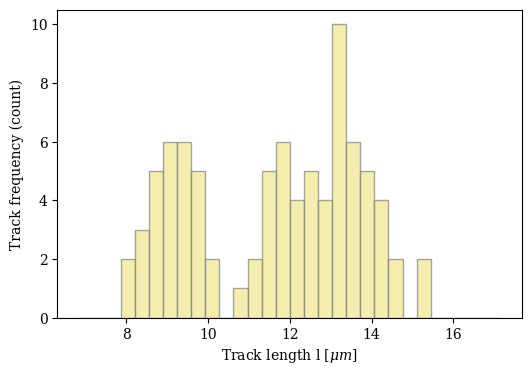

In [3]:
### Reproduce the input data histogram

bins = np.linspace(7, 17, 30)
bin_width = bins[1]-bins[0]
counts = [0, 0, 0, 2, 3, 5, 6, 6, 5, 2, 0, 1, 2, 5, 6, 4, 5, 4, 10, 6, 5, 4, 2, 0, 2, 0, 0, 0, 0, 0]

fig, ax = plt.subplots(figsize = (6,4))

ax.bar(bins, counts, width=bin_width, fc='khaki', ec='gray', alpha=.7)

#ax.set_title('Alpha energy spectrum from fluorescent nuclear track detector \n [Bartz, Zeissler, et al, 2013]')
ax.set_xlabel('Track length l ' + r'$[\mu m]$')
ax.set_ylabel('Track frequency (count)' )

plt.savefig('Nodata.png')

fig.show()

## 1.2 The model

Each atom in the source has its length defined by a normal function $\mathcal{N}_i(\mu_i, \sigma_i)$ with $i \in [1,4]$. There are four atoms, and the goal is to find the mean and standard deviation of each Gaussian. The model is the sum of the normal function $\mathcal{F} = \sum_i \mathcal{N}_i$.

In [4]:
### Define the model

def normal(x, mean=0, sigma=1, norm=1): 
    fac = 1 / (sigma * np.sqrt(2 * np.pi))
    exp = np.exp( (-1/2) * (( (x - mean) / sigma)**2 ) )
    return fac * exp * norm

# 238 U
target_x1 =  np.linspace(7, 16, 150)
target_y1 = []
for x in target_x1:
    target_y1.append(normal(x, mean=10, sigma=.5, norm=7))

# 234 U
target_x2 =  np.linspace(7, 16, 150)
target_y2 = []
for x in target_x2:
    target_y2.append(normal(x, mean=12.2, sigma=.6, norm=6))


# 239 Pu
target_x3 =  np.linspace(7, 16, 150)
target_y3 = []
for x in target_x3:
    target_y3.append(normal(x, mean=13.5, sigma=.3, norm=6))


# 241 Am
target_x4 =  np.linspace(7, 16, 150)
target_y4 = []
for x in target_x4:
    target_y4.append(normal(x, mean=14, sigma=.5, norm=3))


# 241 Am
target_xsum =  np.linspace(7, 16, 150)
target_ysum = []
for i, x in enumerate(target_xsum):
    target_ysum.append(target_y1[i]+target_y2[i]+target_y3[i]+target_y4[i])


/tmp/ipykernel_114893/2642470535.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


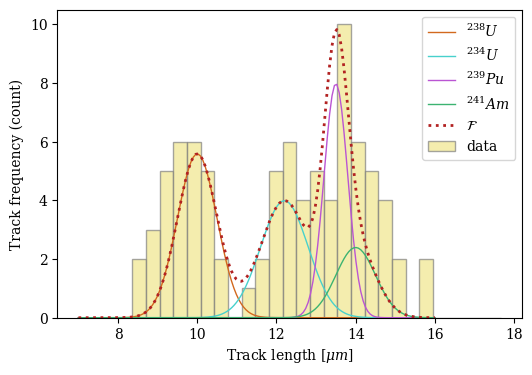

In [5]:
### Plot the result 

bins = np.linspace(7.5, 17.5, 30)
bin_width = bins[1]-bins[0]
counts = [0, 0, 0, 2, 3, 5, 6, 6, 5, 2, 0, 1, 2, 5, 6, 4, 5, 4, 10, 6, 5, 4, 2, 0, 2, 0, 0, 0, 0, 0]

fig, ax = plt.subplots(figsize = (6,4))

ax.bar(bins, counts, width=bin_width, fc='khaki', ec='gray', alpha=.7, label='data')
ax.plot(target_x1, target_y1, lw=1, c='chocolate', label=r'$^{238}U$')
ax.plot(target_x2, target_y2, lw=1, c='mediumturquoise', label=r'$^{234}U$')
ax.plot(target_x3, target_y3, lw=1, c='mediumorchid', label=r'$^{239}Pu$')
ax.plot(target_x4, target_y4, lw=1, c='mediumseagreen', label=r'$^{241}Am$')
ax.plot(target_xsum, target_ysum, lw=2, c='firebrick', ls=':', label=r'$\mathcal{F}$')

#ax.set_title('Alpha energy spectrum from fluorescent nuclear track detector \n [Bartz, Zeissler, et al, 2013]')
ax.set_xlabel('Track length ' + r'$[\mu m]$')
ax.set_ylabel('Track frequency (count)' )
ax.legend(loc='best' )

plt.savefig('avecdata.png')

fig.show()

## 1.3 The Markov Chain

Use a Markov Chain with the Metropolis-Hastings algorithm to find the values of $\mu_i$ and $\sigma_i$. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time

# Données
bins = np.linspace(7, 17, 31)
bin_width = bins[1] - bins[0]
counts = np.array([0, 0, 0, 2, 3, 5, 6, 6, 5, 2, 0, 1, 2, 5, 6, 4, 5, 4, 10, 6, 5, 4, 2, 0, 2, 0, 0, 0, 0, 0])
bin_centers = (bins[:-1] + bins[1:]) / 2


In [7]:
def print_progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=50, fill='█'):
    """
    Affiche une barre de progression dans la console.
    
    :param iteration: Itération actuelle (int)
    :param total: Total des itérations (int)
    :param prefix: Préfixe de la barre (str)
    :param suffix: Suffixe de la barre (str)
    :param decimals: Nombre de décimales dans le pourcentage (int)
    :param length: Longueur de la barre de progression (int)
    :param fill: Caractère de remplissage de la barre (str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
    # Print New Line on Complete
    if iteration == total:
        print()

In [8]:
# Fonction de densité de probabilité pour un mélange de gaussiennes
def densité_G(x, param, norme):
    moy = param[:4]
    sig = param[4:]
    gaussians = np.array([N * np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi)) for mu, sigma, N in zip(moy, sig, norme)])
    return np.sum(gaussians, axis=0), gaussians

In [9]:
# Fonction de vraisemblance
def vraisemblance(data, bins, paras, norme):
    ln_L = 0
    for i in range(len(data)):
        pdf_value = densité_G(bin_centers[i], paras, norme)[0]
        if data[i] > 0 and pdf_value > 0:
            ln_L += pdf_value - data[i] + data[i] * np.log(data[i] / pdf_value + 1e-9)
    #print(ln_L)
    #print(np.exp(-ln_L))
    return np.exp(-ln_L)

In [10]:
# Matrices de covariance pour les sauts

# 1
#cov_moy = np.diag([.005, .005, .005, .005])
#cov_sig = np.diag([.001, .001, .001, .001])

# 2
#cov_moy = np.diag([.002, .002, .002, .002])
#cov_sig = np.diag([.0001, .0001, .0001, .0001])

#3
#cov_moy = np.diag([.0005, .0005, .0005, .0005])
#cov_sig = np.diag([.00005, .00005, .00005, .00005])

# 4 Moyennes Good
cov_moy = np.diag([.001, .001, .001, .001])
cov_sig = np.diag([1e-8, .5e-8, .1e-9, .1e-6])

# 5
#cov_moy = np.diag([.002, .002, .002, .002])
#cov_sig = np.diag([.5e-7, .5e-7, .5e-7, .5e-7])

# 6 Marche pas du tout
#cov_moy = np.diag([.002, .002, .002, .002])
#cov_sig = np.diag([.1, .1, .1, .1])

# 7
#cov_moy = np.diag([.0005, .0005, .0005, .0005])
#cov_sig = np.diag([.1e-10, .1e-10, .1e-10, .1e-10])

cov = np.block([
    [cov_moy, np.zeros((4, 4))],
    [np.zeros((4, 4)), cov_sig]
])

In [11]:
cov

array([[1.e-03, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 1.e-03, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 1.e-03, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 1.e-03, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-08, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 5.e-09, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-10, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-07]])

In [12]:
# Fonction pour générer les nouveaux paramètres par un saut gaussien multivarié
def jump(param):
    new_param = np.random.multivariate_normal(param, cov)
    return new_param

In [13]:
param_true = [10, 12.2, 13.5, 14, 0.5, 0.6, 0.3, 0.5]

test = []
compt = []
for i in range(int(1)):
    test.append(np.random.multivariate_normal(param_true, cov))
    compt.append(i)
    
test = np.array(test)
compt = np.array(compt)

print('Avant :', param_true)
print('Après :', test)

Avant : [10, 12.2, 13.5, 14, 0.5, 0.6, 0.3, 0.5]
Après : [[ 9.99491152 12.16968049 13.48554162 13.97462572  0.49997704  0.60003281
   0.30000735  0.50017121]]


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([11.66968049, 11.71968049, 11.76968049, 11.81968049, 11.86968049,
        11.91968049, 11.96968049, 12.01968049, 12.06968049, 12.11968049,
        12.16968049, 12.21968049, 12.26968049, 12.31968049, 12.36968049,
        12.41968049, 12.46968049, 12.51968049, 12.56968049, 12.61968049,
        12.66968049]),
 <BarContainer object of 20 artists>)

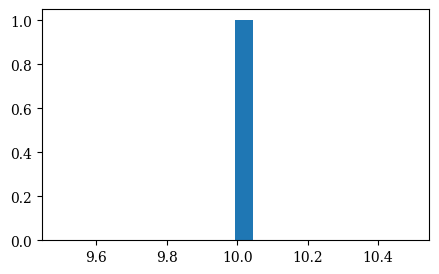

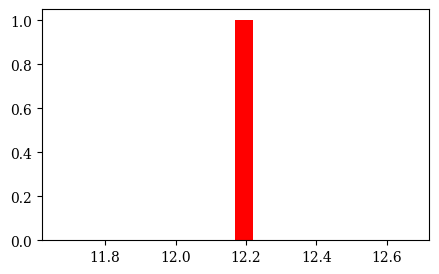

In [14]:
plt.figure(figsize=(5, 3))
plt.hist(test[:, 0], bins=20)

plt.figure(figsize=(5, 3))
#plt.scatter(test[:, 1], compt, s=1, alpha=0.6, color = 'r')
plt.hist(test[:, 1], bins=20, color='r')

#np.mean(test[:, 0])

In [15]:
# Algorithme de Metropolis - Hastings
def MH(data, bins, param_ini, iterations, norme):
    params = param_ini    
    comptage = [0]
    parametres_finaux = [params] 
    vraisemblances = []
    
    old_L = vraisemblance(data, bin_centers, params, norme)
    #print('old_L ' , old_L)
    #print('test', vraisemblance(data, bin_centers, params, norme))
    vraisemblances.append(old_L)
    
    for j in range(iterations):
        print_progress_bar(j + 1, iterations, prefix='Progress:', suffix='Complete', length=50)

        
        while True:
            new_params = jump(params)
            if np.all((8 <= new_params[:4]) & (new_params[:4] <= 16)) and np.all((0 <= new_params[4:]) & (new_params[4:] <= 1)):
                break
        
        #print('new_params ', new_params)
        new_params[4:] = np.abs(new_params[4:])
        #print('new_params ', new_params)
        new_L = vraisemblance(data, bin_centers, new_params, norme)
        #print(' if ', old_L, stats.multivariate_normal.pdf(params, new_params, cov) )
        if old_L != 0 and stats.multivariate_normal.pdf(params, new_params, cov) != 0:
            r = (new_L * stats.multivariate_normal.pdf(params, new_params, cov)) / (old_L * stats.multivariate_normal.pdf( new_params, params,cov))
            #print(' J/J ', stats.multivariate_normal.pdf(params, new_params, cov)/stats.multivariate_normal.pdf( new_params, params,cov))
        else:
            r = 0
        if r >= 1 or np.random.uniform(0, 1) < r:
            params = new_params
        old_L = new_L
        comptage.append(j)
        parametres_finaux.append(params)
        vraisemblances.append(old_L)
    return params, comptage, parametres_finaux, vraisemblances

In [16]:
# Paramètres initiaux
moy_ini = np.array([10, 10, 10, 10])
sig_ini = np.array([0.25, 0.25, 0.25, 0.25])
norme = np.array([7, 6, 6, 3])
param_ini = np.concatenate((moy_ini, sig_ini))

iterations = 2

In [17]:
param_true = [10, 12.2, 13.5, 14, 0.5, 0.6, 0.3, 0.5]

In [40]:
def burn_in(parametres_finaux, burn_in_fraction):
    burn_in_length = int(len(parametres_finaux) * burn_in_fraction)
    return parametres_finaux[burn_in_length:]

burn_in_fraction = 0.3

In [ ]:
iterations = 1000000

paras_esti, comptage, parametres_finaux, vraisemblances = MH(counts, bins, param_true, iterations, norme)


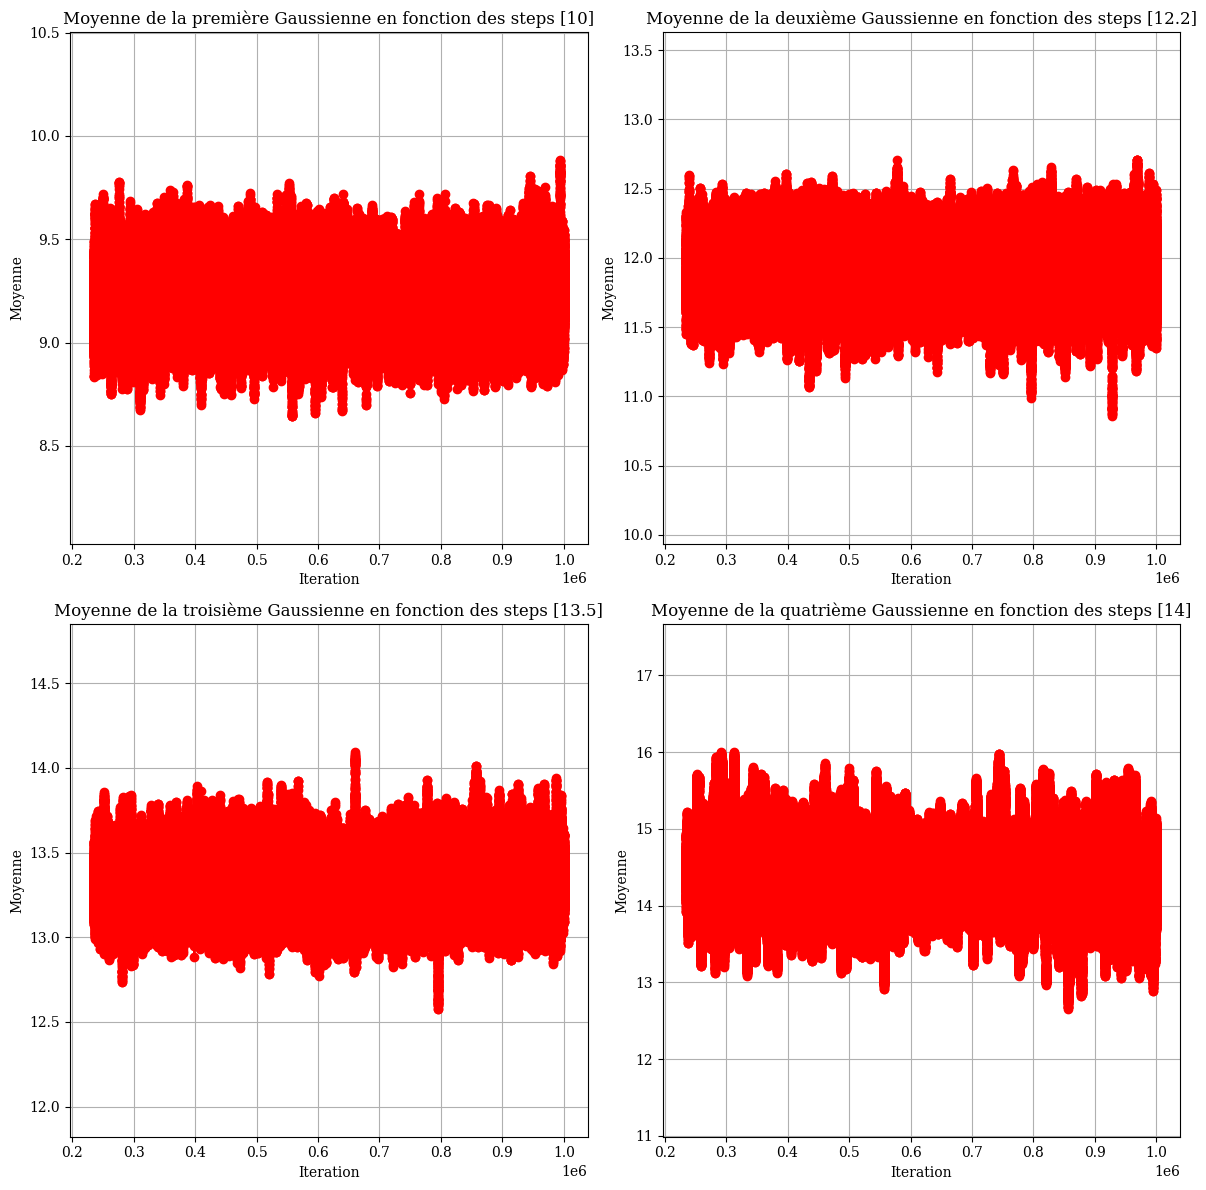

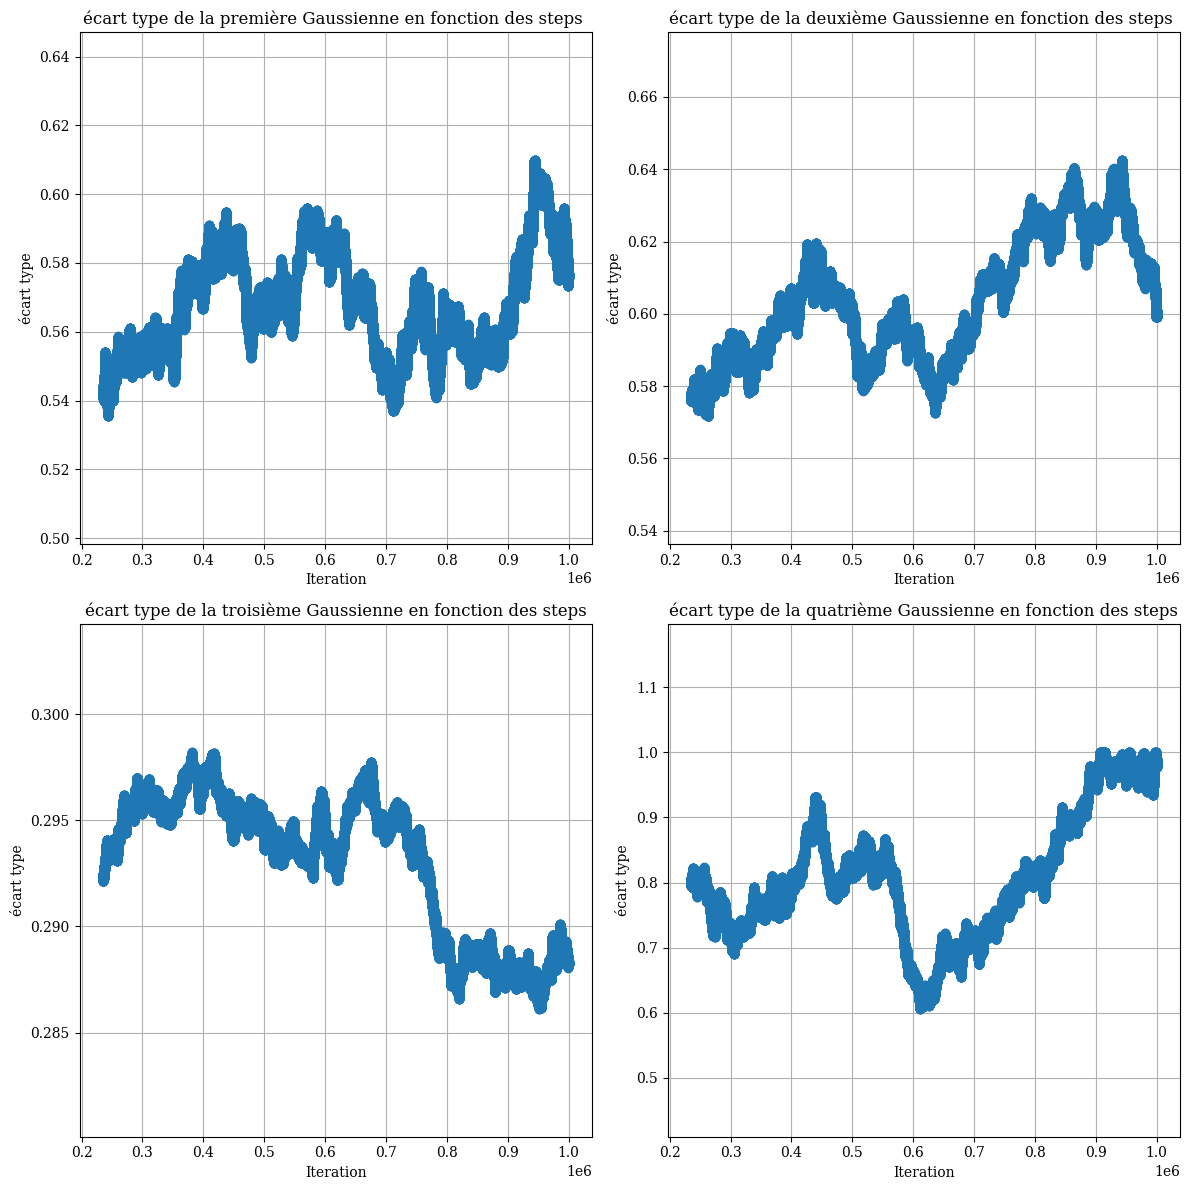

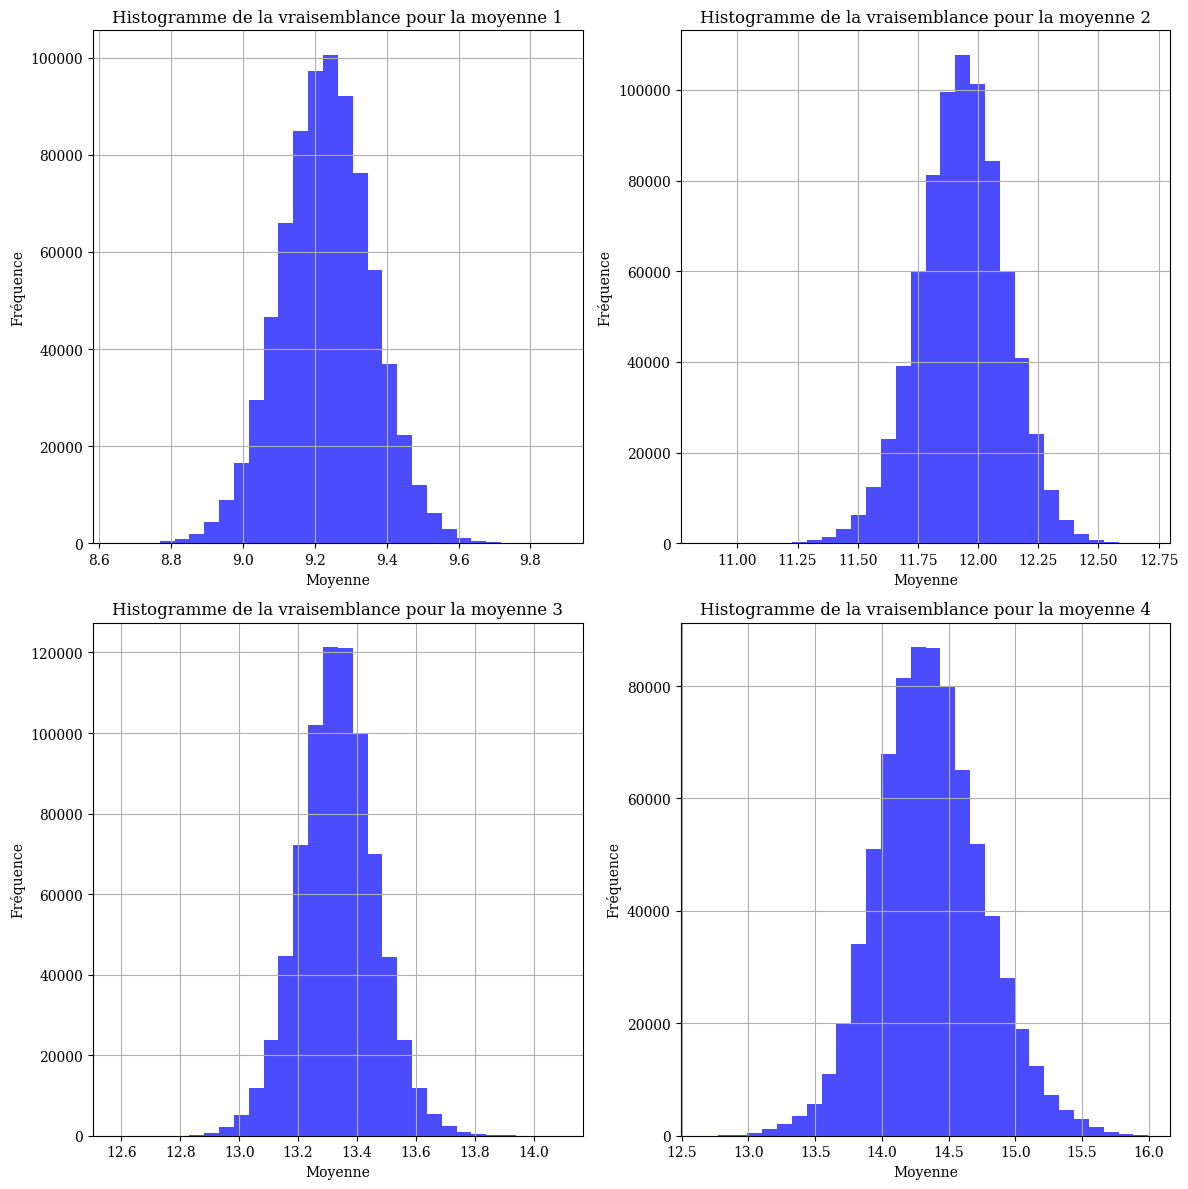

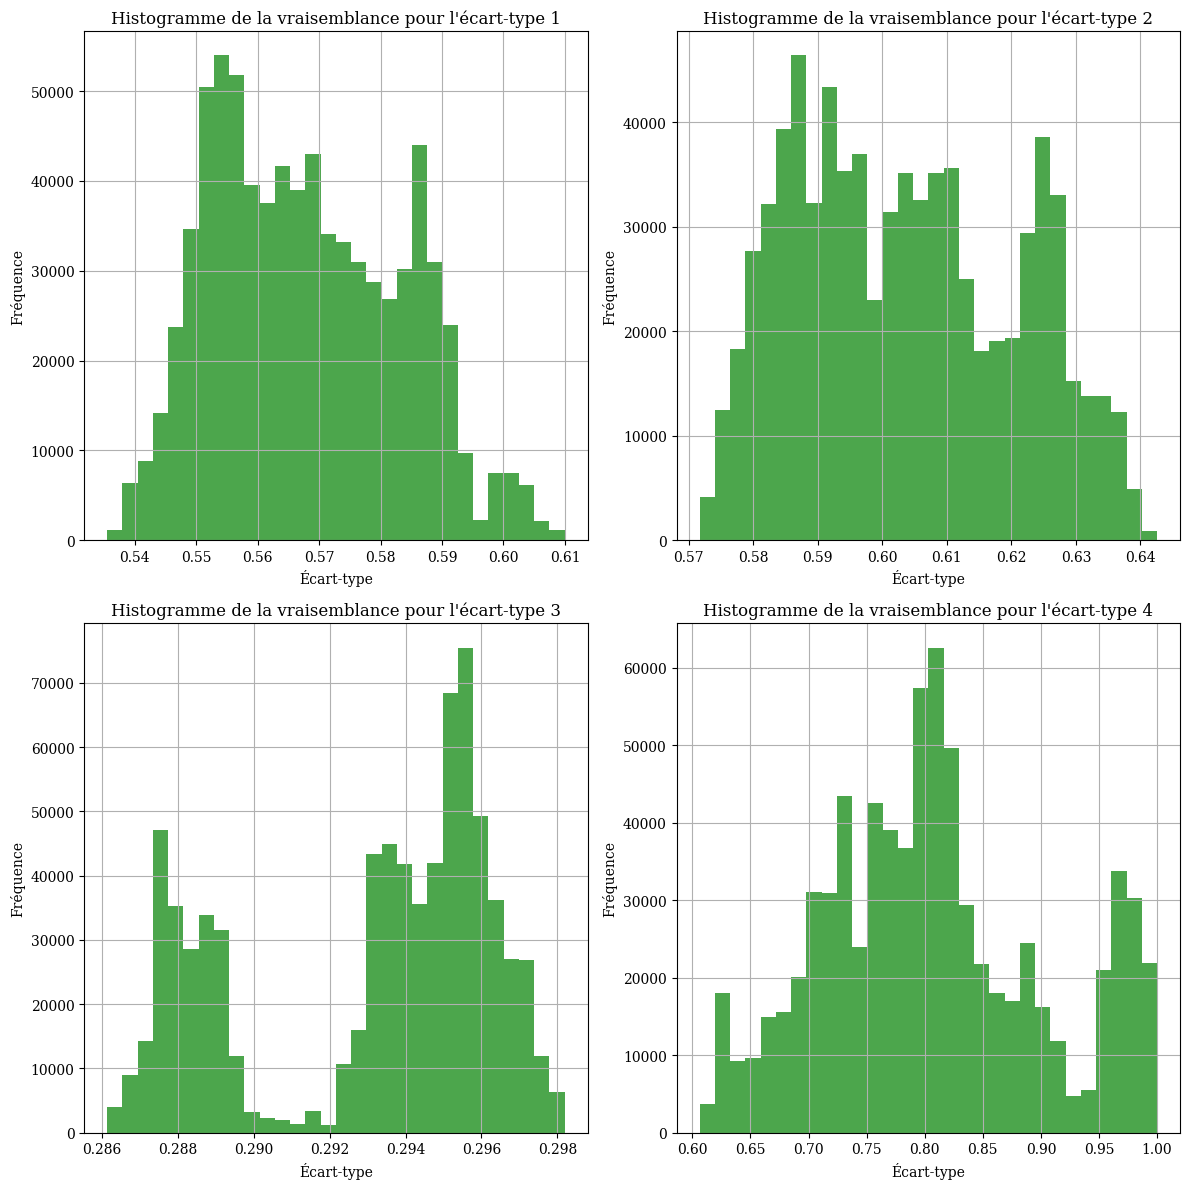

Valeurs avec la plus grande fréquence pour les moyennes : [9.222353406026441, 11.905125096096963, 13.284685890425706, 14.215797723085288]
Valeurs avec la plus grande fréquence pour les écarts-types : [0.5528624455736648, 0.5858811516201252, 0.2953795927717328, 0.8030944054153429]


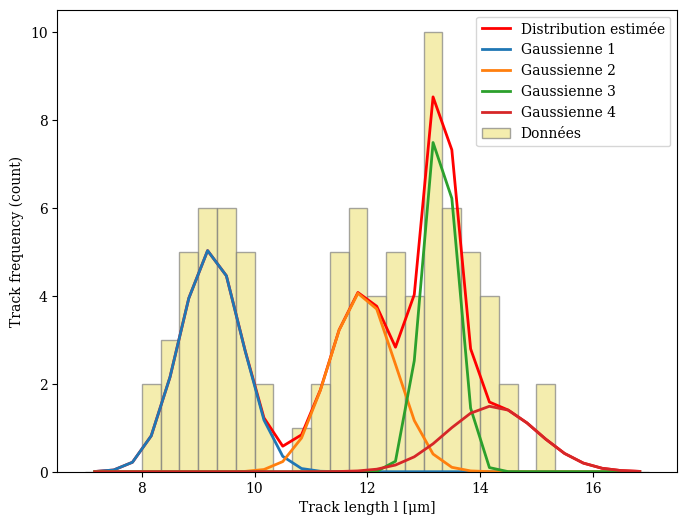

In [31]:
parametres_finaux = burn_in(parametres_finaux, burn_in_fraction)
comptage = burn_in(comptage, burn_in_fraction)

moyenne = parametres_finaux[:4]
ecart = parametres_finaux[4:]
#print("Moyenne :", moyenne)
#print("Ecart :", ecart)

# Affichage des résultats

# Affichage des moyennes estimées 
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

titles = [
    'Moyenne de la première Gaussienne en fonction des steps [10]',
    'Moyenne de la deuxième Gaussienne en fonction des steps [12.2]',
    'Moyenne de la troisième Gaussienne en fonction des steps [13.5]',
    'Moyenne de la quatrième Gaussienne en fonction des steps [14]'
]

for i in range(4):
    axes[i].plot(comptage, [m[i] for m in parametres_finaux], marker='o', linestyle='-', color ='r')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel('Moyenne')
    axes[i].grid(True)
    axes[i].margins(y=0.5)  # Dézoomer sur l'axe y

plt.tight_layout()
plt.show()

# Affichage des traces des écarts types
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

titles = [
    'écart type de la première Gaussienne en fonction des steps ',
    'écart type de la deuxième Gaussienne en fonction des steps ',
    'écart type de la troisième Gaussienne en fonction des steps',
    'écart type de la quatrième Gaussienne en fonction des steps'
]

for i in range(4):
    axes[i].plot(comptage, [m[i+4] for m in parametres_finaux], marker='o', linestyle='-')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Iteration')
    axes[i].set_ylabel('écart type')
    axes[i].grid(True)
    axes[i].margins(y=0.5)  # Dézoomer sur l'axe y

plt.tight_layout()
plt.show()



# Tracer l'histogramme des vraisemblances pour chaque moyenne
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
best_moy = []

for i in range(4):
    n, bins, patches = axes[i].hist([m[i] for m in parametres_finaux], bins=30, color='blue', alpha=0.7)
    axes[i].set_title(f'Histogramme de la vraisemblance pour la moyenne {i+1}')
    axes[i].set_xlabel('Moyenne')
    axes[i].set_ylabel('Fréquence')
    axes[i].grid(True)

    # Trouver la valeur avec la plus grande fréquence
    best_moy.append(bins[np.argmax(n)])

plt.tight_layout()
plt.show()

# Tracer l'histogramme des vraisemblances pour chaque écart-type
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
best_sig = []

for i in range(4):
    n, bins, patches = axes[i].hist([s[i+4] for s in parametres_finaux], bins=30, color='green', alpha=0.7)
    axes[i].set_title(f'Histogramme de la vraisemblance pour l\'écart-type {i+1}')
    axes[i].set_xlabel('Écart-type')
    axes[i].set_ylabel('Fréquence')
    axes[i].grid(True)
    # Trouver la valeur avec la plus grande fréquence
    best_sig.append(bins[np.argmax(n)])

plt.tight_layout()
plt.show()

print("Valeurs avec la plus grande fréquence pour les moyennes :", best_moy)
print("Valeurs avec la plus grande fréquence pour les écarts-types :", best_sig)

best_paras = np.concatenate((best_moy, best_sig))


plt.figure(figsize=(8, 6))
plt.bar(bin_centers, counts, width=bin_width, fc='khaki', ec='gray', alpha=0.7, label='Données')
densité_totale, gaussians = densité_G(bin_centers, best_paras, norme)
plt.plot(bin_centers, densité_totale, color='red', lw=2, label='Distribution estimée')

for i, gaussian in enumerate(gaussians):
    plt.plot(bin_centers, gaussian, lw=2, label=f'Gaussienne {i+1}')

#plt.title('Estimation de la distribution à partir des données observées par la méthode de Metropolis-Hastings pour ' + str(len(comptage)-1) + ' steps')
plt.xlabel('Track length l [μm]')
plt.ylabel('Track frequency (count)')
plt.legend()

plt.savefig('Final.png')
plt.show()

/tmp/ipykernel_114893/3375669873.py:4: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 1200x1200 with 4 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(img, shrink=1, aspect=10)


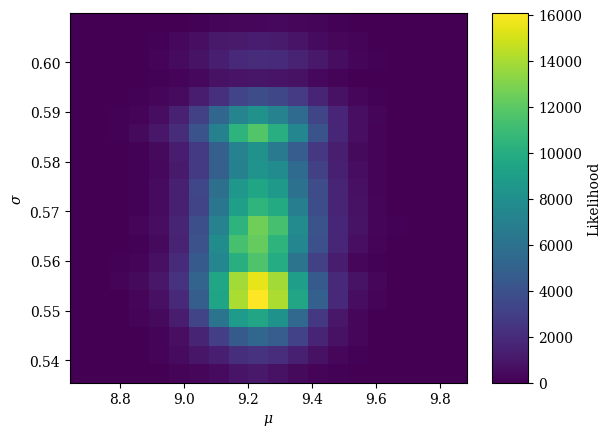

In [32]:
heatmap, xedges, yedges, img = plt.hist2d([s[0] for s in parametres_finaux], [m[4] for m in parametres_finaux], bins=20, cmap='viridis')#, range=[[0, 350], [0, 2000]])
plt.ylabel(r'$\sigma$')
plt.xlabel(r'$\mu$')
cbar = fig.colorbar(img, shrink=1, aspect=10)
cbar.set_label('Likelihood')

plt.savefig('gauss1.png')

/tmp/ipykernel_114893/4283645982.py:4: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 1200x1200 with 4 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(img, shrink=1, aspect=10)


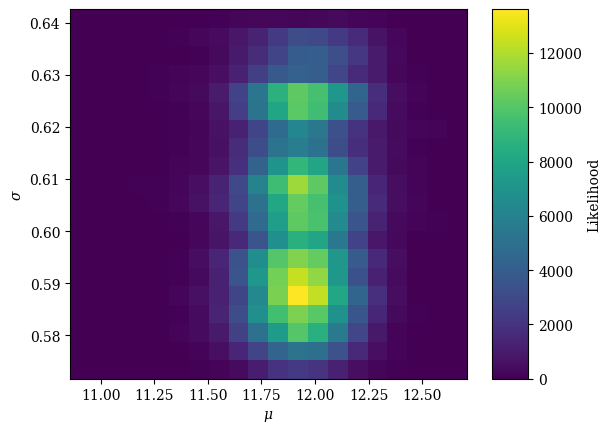

In [33]:
heatmap, xedges, yedges, img = plt.hist2d([s[1] for s in parametres_finaux], [m[5] for m in parametres_finaux], bins=20, cmap='viridis')#, range=[[0, 350], [0, 2000]])
plt.ylabel(r'$\sigma$')
plt.xlabel(r'$\mu$')
cbar = fig.colorbar(img, shrink=1, aspect=10)
cbar.set_label('Likelihood')

plt.savefig('gauss2.png')

/tmp/ipykernel_114893/3165371461.py:4: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 1200x1200 with 4 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(img, shrink=1, aspect=10)


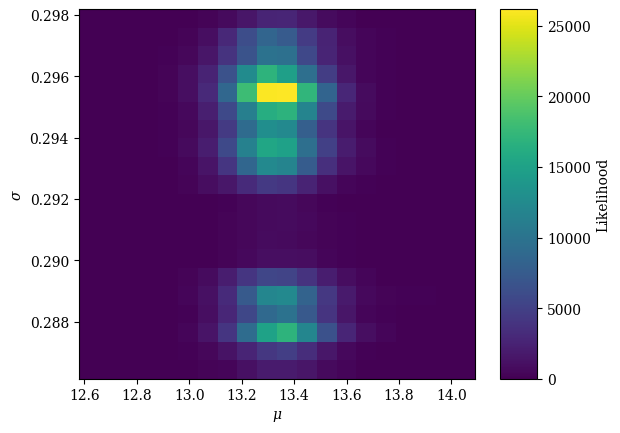

In [34]:
heatmap, xedges, yedges, img = plt.hist2d([s[2] for s in parametres_finaux], [m[6] for m in parametres_finaux], bins=20, cmap='viridis')#, range=[[0, 350], [0, 2000]])
plt.ylabel(r'$\sigma$')
plt.xlabel(r'$\mu$')
cbar = fig.colorbar(img, shrink=1, aspect=10)
cbar.set_label('Likelihood')

plt.savefig('gauss3.png')

/tmp/ipykernel_114893/2771197985.py:4: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 1200x1200 with 4 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(img, shrink=1, aspect=10)


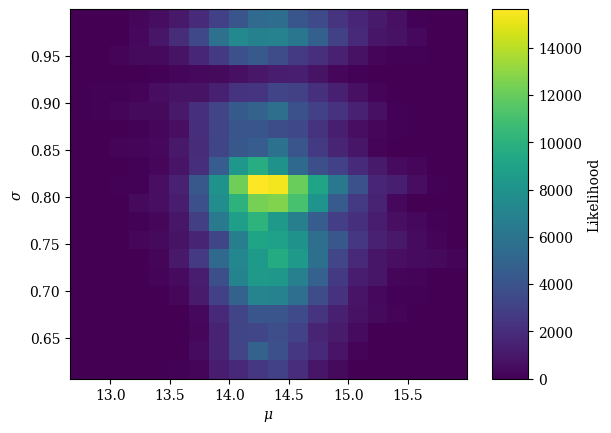

In [35]:
heatmap, xedges, yedges, img = plt.hist2d([s[3] for s in parametres_finaux], [m[7] for m in parametres_finaux], bins=20, cmap='viridis')#, range=[[0, 350], [0, 2000]])
plt.ylabel(r'$\sigma$')
plt.xlabel(r'$\mu$')
cbar = fig.colorbar(img, shrink=1, aspect=10)
cbar.set_label('Likelihood')
plt.savefig('gauss4.png')

In [36]:
np.savetxt('moyennes1.csv', parametres_finaux, delimiter=',')


In [3]:
parametres_finaux = np.genfromtxt('moyennes1.csv', delimiter=',')
parametres_finaux = burn_in(parametres_finaux, burn_in_fraction)


NameError: name 'burn_in' is not defined

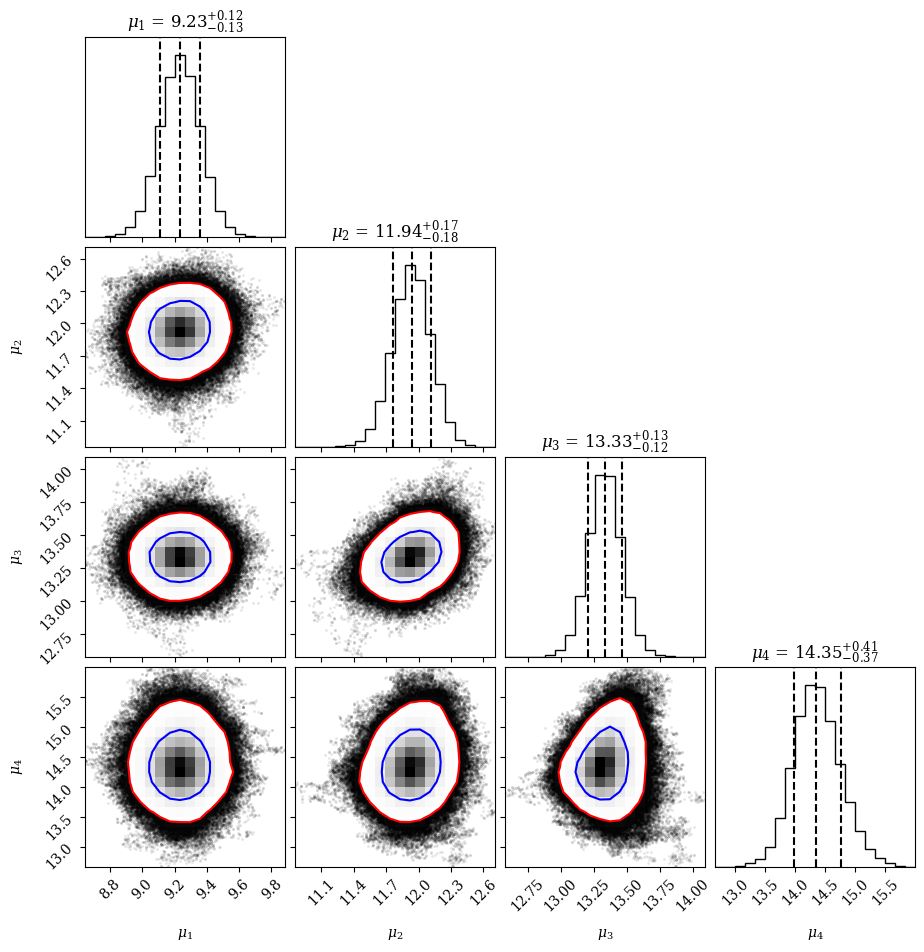

In [21]:
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

contour_colors = ['red', 'blue']

figure = corner.corner(
    parametres_finaux[:,:4],
    labels = [r'$\mu_1$', r'$\mu_2$', r'$\mu_3$', r'$\mu_4$'],
    max_n_ticks=7,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt='.2f',
    cmap  = 'viridis',
    quantiles=[0.16, 0.5, 0.84],
    plot_density = True, plot_contours = True, levels = (0.68, 0.95), contour_kwargs = {"colors": contour_colors},
    color = 'black',

)

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 3))
#ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)


plt.savefig('cornerplot_joli.png')
plt.show()

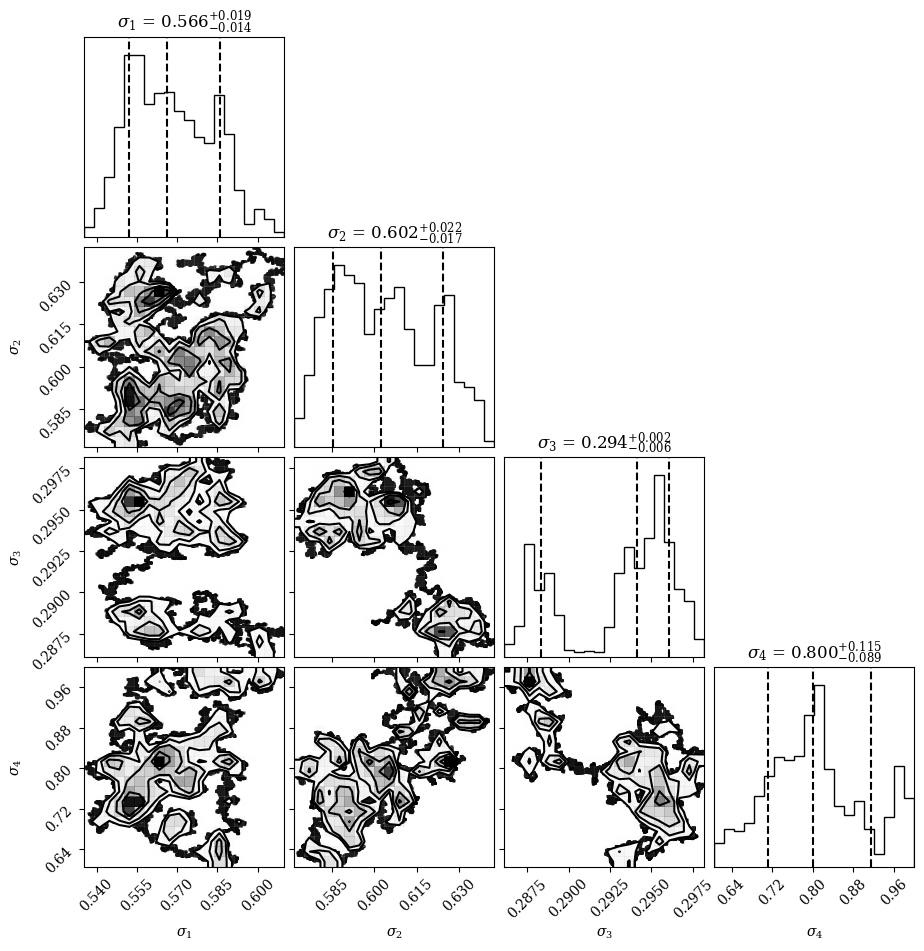

In [39]:
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

figure = corner.corner(
    parametres_finaux[:,4:],
    labels = [r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$', r'$\sigma_4$'],
    max_n_ticks=5,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt='.3f',
    cmap  = 'viridis',
    quantiles=[0.16, 0.5, 0.84],
)


formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 3))
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

plt.savefig('cornerplot_encore_plus_horrible.png')
plt.show()

In [28]:
parametres_finaux

array([[ 9.26235441, 12.05085925, 13.32803137, ...,  0.58235112,
         0.29701036,  0.58621572],
       [ 9.25270954, 12.06225567, 13.36501074, ...,  0.58246375,
         0.29701309,  0.58530203],
       [ 9.25270954, 12.06225567, 13.36501074, ...,  0.58246375,
         0.29701309,  0.58530203],
       ...,
       [ 9.36434402, 11.98973432, 13.45247159, ...,  0.59953496,
         0.28832342,  0.97858733],
       [ 9.34120439, 12.00605988, 13.449492  , ...,  0.59955902,
         0.28834359,  0.97855208],
       [ 9.36242399, 12.00949948, 13.44913571, ...,  0.5996053 ,
         0.28834838,  0.97850686]])